# EDA Notebook

In [1]:
import s3fs
import boto3
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7 #amber's s3 bucket
# Alison's s3 bucket

In [3]:
# csv file
df_books_filtered = pd.read_csv('s3://ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7/books_filtered.csv')
text_data = pd.read_csv('s3://ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7/books_filtered_colsreduced.csv')
print('Total Text DF size:', len(text_data))
token_data = pd.read_csv('s3://ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7/tokenized_data (1).csv')
#model_data = pd.read_csv('s3://book-data-ucb-capstone-s2022/tokenized_data.csv')
#print('Tokenized Text DF Size:', len(model_data))

Total Text DF size: 29652


In [4]:
def preprocess_text(text):

  #lowercase text
  text_preprocessed = text.lower()
  #remove punctuation
  text_preprocessed = re.sub(r'[^a-zA-Z ]+', '', text_preprocessed)
  #tokenize for stopword removal
  text_preprocessed = word_tokenize(text_preprocessed)
  #remove stopwords
  text_preprocessed = [word for word in text_preprocessed if word not in stopwords.words('english')]
  #join to make string again
  #text_preprocessed = (" ").join(text_preprocessed)

  return text_preprocessed

In [22]:
%%time
text_data['tokens'] = text_data['description'].apply(lambda x: preprocess_text(x))

CPU times: user 5min 1s, sys: 25.7 s, total: 5min 26s
Wall time: 5min 26s


In [6]:
text_data['tokens'].head()

0    [winning, means, fame, fortunelosing, means, c...
1    [door, end, silent, corridor, haunting, harry,...
2    [unforgettable, novel, childhood, sleepy, sout...
3    [alternate, cover, edition, isbn, since, immed...
4    [three, things, absolutely, positivefirst, edw...
Name: tokens, dtype: object

In [32]:
#save dataset to csv
text_data.to_csv('text_data_AR.csv')

In [ ]:
#upload dataset to s3 & google drive

#Creating Session With Boto3.
#session = boto3.Session(
#aws_access_key_id='<your_access_key_id>',
#aws_secret_access_key='<your_secret_access_key>'
#)

#Creating S3 Resource From the Session.
#s3 = session.resource('s3')

#result = s3.Bucket('ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7').upload_file('E:/temp/testfile.txt','file2_uploaded_by_boto3.txt')

#print(result)

# EDA Plan

Overall EDA
1. Book counts across main genres with visualization (histogram)
2. Average rating per book - histogram 
3. % of dataset with award winning books
4. Common genres paired together
5. Number of Genres

Description EDA
1. Histogram of description length buckets (nice to have)
2. Histogram of tokens per 'description' 
3. bi-grams and tri-grams per description 
4. most frequent words in descriptions - histograms - common adjectives used to describe books 
5. word types in description
6. Average number of sentences in description

## Overall EDA

In [5]:
df_genres = token_data[['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance']]
df_genres.count()

Young Adult       10264
Childrens          3706
New Adult          1289
Fantasy           12677
History              55
Dystopia           1522
Manga               593
Thriller           3987
Graphic Novels     1399
Romance           11624
dtype: int64

<AxesSubplot:>

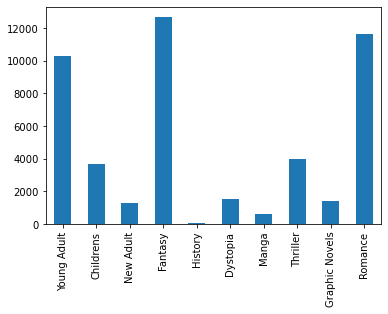

In [6]:
df_genres.count().plot(kind='bar')

In [7]:
genre_combos = df_genres.groupby(['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance'], dropna=False, as_index=False,).size().sort_values(by='size', axis=0, ascending=False)

In [8]:
genre_combos[4:15]

,Young Adult,Childrens,New Adult,Fantasy,History,Dystopia,Manga,Thriller,Graphic Novels,Romance,size
52,Young Adult,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,2121
114,NaN,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,1993
13,Young Adult,Childrens,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,1418
69,Young Adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance,1059
20,Young Adult,Childrens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1017
53,Young Adult,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,969
70,Young Adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579
31,Young Adult,NaN,New Adult,NaN,NaN,NaN,NaN,NaN,NaN,Romance,561
111,NaN,NaN,NaN,Fantasy,NaN,NaN,NaN,Thriller,NaN,NaN,487
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,Romance,440


In [9]:
award_count = 0
for x in df_books_filtered['awards']:
    if x != "[]":
        award_count = award_count + 1

In [10]:
award_count

7655

In [11]:
print("Percentage of award winning books:", 7655 / len(df_books_filtered))

Percentage of award winning books: 0.2581613381896668


<AxesSubplot:>

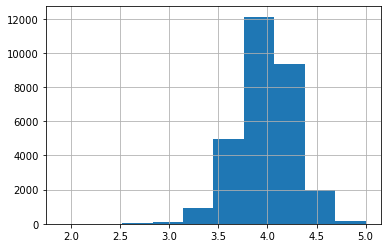

In [12]:
df_books_filtered['rating'].hist()

In [118]:
df_books_filtered['rating'].value_counts(bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

(3.5, 4.0]       14091
(4.0, 4.5]       13241
(3.0, 3.5]        1444
(4.5, 5.0]         812
(2.5, 3.0]          61
(1.5, 2.0]           2
(2.0, 2.5]           1
(-0.001, 0.5]        0
(0.5, 1.0]           0
(1.0, 1.5]           0
Name: rating, dtype: int64

<AxesSubplot:>

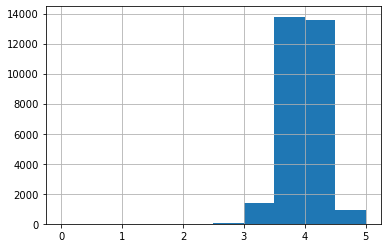

In [116]:
df_books_filtered['rating'].hist(bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

In [14]:
df_books_filtered['rating'].mean()

3.9797497639282264

<AxesSubplot:>

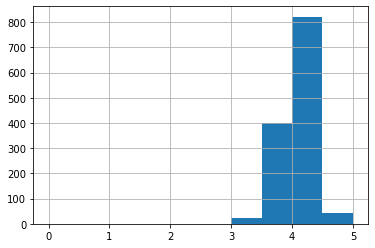

In [121]:
df_books_filtered[df_books_filtered['New Adult'] == 'New Adult']['rating'].hist(bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

In [126]:
for i in df_genres.columns:
    x = df_books_filtered[df_books_filtered[i] == i]['rating'].mean()
    print('Avg Rating of ', i, ' is ', x)

Avg Rating of  Young Adult  is  3.98109801247077
Avg Rating of  Childrens  is  4.029471127900705
Avg Rating of  New Adult  is  4.078425135764161
Avg Rating of  Fantasy  is  4.006073992269465
Avg Rating of  History  is  4.098181818181817
Avg Rating of  Dystopia  is  3.948291721419182
Avg Rating of  Manga  is  4.23920741989882
Avg Rating of  Thriller  is  3.9241234010534254
Avg Rating of  Graphic Novels  is  4.178849177984272
Avg Rating of  Romance  is  3.9833981417756243


In [127]:
4.23920741989882 - 3.9797497639282264

0.25945765597059367

In [19]:
token_data

,Unnamed: 0.1,Unnamed: 0,bookId,title,series,author,description,isbn,genres,pages,...,New Adult,Fantasy,History,Dystopia,Manga,Thriller,Graphic Novels,Romance,tokens,token_length
0,0,0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,9.78044E+12,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",374,...,NaN,Fantasy,NaN,Dystopia,NaN,NaN,NaN,Romance,"{'sentence', 'america', 'take', 'life', 'conte...",686
1,1,1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",There is a door at the end of a silent corrido...,9.78044E+12,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",870,...,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,"{'strength', 'lot', 'ordinary', 'end', 'things...",730
2,2,2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,1E+13,"['Classics', 'Fiction', 'Historical Fiction', ...",324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'published', 'experience', 'roots', 'classicc...",765
3,3,3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",Alternate cover edition of ISBN 9780679783268S...,1E+13,"['Classics', 'Fiction', 'Romance', 'Historical...",279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance,"{'austens', 'wit', 'cover', 'austen', 'popular...",636
4,4,4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,About three things I was absolutely positive.\...,9.78032E+12,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",501,...,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,"{'positivefirst', 'himand', 'things', 'part', ...",307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29647,29647,52473,11492014-fractured,Fractured,Fateful #2,Cheri Schmidt (Goodreads Author),The Fateful Trilogy continues with Fractured. ...,2.94001E+12,"['Vampires', 'Paranormal', 'Young Adult', 'Rom...",0,...,New Adult,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,"{'trilogy', 'continues', 'want', 'destroy', 'd...",547
29648,29648,52474,11836711-anasazi,Anasazi,Sense of Truth #2,Emma Michaels,"'Anasazi', sequel to 'The Thirteenth Chime' by...",1E+13,"['Mystery', 'Young Adult']",190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'david', 'desert', 'arrived', 'wants', 'cant'...",349
29649,29649,52475,10815662-marked,Marked,Soul Guardians #1,Kim Richardson (Goodreads Author),--READERS FAVORITE AWARDS WINNER 2011--Sixteen...,9.78146E+12,"['Fantasy', 'Young Adult', 'Paranormal', 'Ange...",280,...,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,"{'hurtles', 'yearold', 'life', 'david', 'night...",488
29650,29650,52476,11330278-wayward-son,Wayward Son,NaN,"Tom Pollack (Goodreads Author), John Loftus (G...",A POWERFUL TREMOR UNEARTHS AN ANCIENT SECRETBu...,9.78145E+12,"['Fiction', 'Mystery', 'Historical Fiction', '...",507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'suspense', 'relic', 'near', 'vesuvius', 'evi...",888


# Description EDA

## Token EDA

In [23]:
text_data['token_length'] = text_data['tokens'].apply(lambda x: len(x))

In [24]:
text_data['token_length'].mean()

78.08970727101038

In [25]:
text_data['token_length'].min()

0

In [26]:
text_data['token_length'].max()

759

<AxesSubplot:>

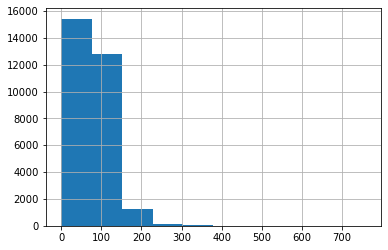

In [27]:
text_data['token_length'].hist()

In [28]:
#most frequent tokens
all_tokens = []
pos = []
for i in text_data['tokens']:
    all_tokens = i + all_tokens

In [29]:
df_all_tokens = pd.DataFrame(all_tokens, columns = ['token']) 

In [30]:
#save dataset to csv
df_all_tokens.to_csv('df_all_tokens.csv')

In [31]:
df_all_tokens['token'].value_counts()[0:50]

one        16015
life       13529
new        12732
world      10561
love        9361
time        7001
story       6892
first       6425
family      6267
man         5940
find        5879
must        5813
novel       5730
two         5679
shes        5564
years       5446
young       5404
even        5349
book        5264
never       5153
like        4571
way         4529
back        4512
ever        4282
could       4266
hes         4170
war         3988
home        3818
past        3764
series      3753
finds       3742
secret      3690
woman       3685
people      3628
friends     3574
make        3562
girl        3555
lives       3431
best        3425
dark        3418
death       3381
would       3370
get         3365
author      3313
heart       3295
help        3243
old         3141
father      3084
knows       3071
may         3058
Name: token, dtype: int64

<AxesSubplot:>

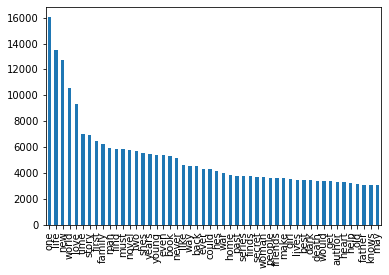

In [26]:
df_all_tokens['token'].value_counts()[0:50].plot.bar()

## Full Text EDA

In [27]:
text_data['description_len'] = text_data['description'].apply(lambda x: len(x))

In [28]:
text_data['description_len'].min()

6

In [29]:
text_data['description_len'].max()

7802

In [30]:
text_data['description_len'].mean()

831.800182112505

<AxesSubplot:>

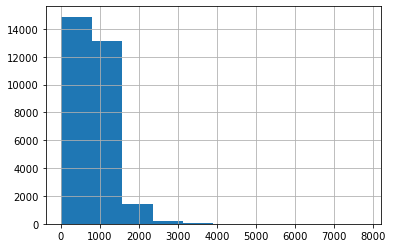

In [31]:
text_data['description_len'].hist()

In [32]:
text_data['sentence_count'] = text_data['description'].apply(lambda x: x.count('.'))

In [33]:
text_data['sentence_count'].mean()

7.908100634021314

In [34]:
text_data['sentence_count'].min()

0

In [35]:
text_data['sentence_count'].max()

112

<AxesSubplot:>

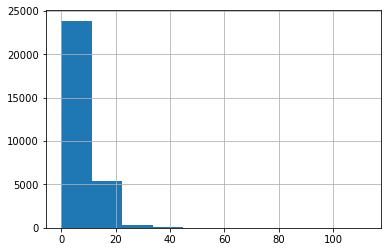

In [36]:
text_data['sentence_count'].hist()

## Example Bi/trigams

In [82]:
import nltk
>>> from nltk.collocations import *

# Example

In [83]:
sample = text_data['description'][0]
sample = sample.lower()
sample = re.sub(r'[^a-zA-Z ]+', '', sample)

In [84]:
sample

'winning means fame and fortunelosing means certain deaththe hunger games have begun   in the ruins of a place once known as north america lies the nation of panem a shining capitol surrounded by twelve outlying districts the capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual hunger games a fight to the death on live tvsixteenyearold katniss everdeen regards it as a death sentence when she steps forward to take her sisters place in the games but katniss has been close to dead beforeand survival for her is second nature without really meaning to she becomes a contender but if she is to win she will have to start making choices that weight survival against humanity and life against love'

In [86]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(sample))
#finder.apply_freq_filter(3)
finder.nbest(bigram_measures.pmi, 15)
#finder.nbest(trigram_measures.pmi, 15)
#finder.nbest(fourgram_measures.pmi, 15)

[('america', 'lies'),
 ('been', 'close'),
 ('certain', 'deaththe'),
 ('choices', 'that'),
 ('dead', 'beforeand'),
 ('everdeen', 'regards'),
 ('forcing', 'them'),
 ('girl', 'between'),
 ('has', 'been'),
 ('live', 'tvsixteenyearold'),
 ('making', 'choices'),
 ('nature', 'without'),
 ('north', 'america'),
 ('on', 'live'),
 ('one', 'boy')]

## Pre-Processing

In [90]:
def simple_processing(sample):
    sample = sample.lower()
    sample = re.sub(r'[^a-zA-Z ]+', '', sample)
    #sample = word_tokenize(sample)
    return sample

In [91]:
text_data['desc_bigrams'] = text_data['description'].apply(lambda x: simple_processing(x))

## Bigrams

In [94]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_list = []
for i in range(0, len(text_data)):
    sample = text_data['desc_bigrams'][i]
    finder = BigramCollocationFinder.from_words(word_tokenize(sample))
    top_15 = finder.nbest(bigram_measures.pmi, 15)
    bigram_list = bigram_list + top_15

In [97]:
df_bigrams = pd.DataFrame(bigram_list)

In [99]:
df_bigrams.value_counts()

0            1       
bestselling  author      1017
best         friend       786
but          when         609
each         other        534
finds        herself      400
                         ... 
catch        part           1
             poachers       1
             polio          1
             raccoons       1
zone         more           1
Length: 273812, dtype: int64

In [104]:
df_bigrams.to_csv('df_bigrams.csv')

In [110]:
bi_vc = df_bigrams.value_counts().reset_index(name='counts')
bi_vc.to_csv('bi_value_counts.csv')

## Trigrams

In [101]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
trigram_list = []
for i in range(0, len(text_data)):
    sample = text_data['desc_bigrams'][i]
    finder = TrigramCollocationFinder.from_words(word_tokenize(sample))
    top_15 = finder.nbest(trigram_measures.pmi, 15)
    trigram_list = trigram_list + top_15

In [102]:
df_trigrams = pd.DataFrame(trigram_list)

In [103]:
df_trigrams.value_counts()

0          1              2             
new        york           times             369
alternate  cover          edition           248
new        york           city              102
can        be             found             101
before     its            too                98
                                           ... 
deep       philosophical  questions           1
                          messaging           1
           personal       turmoil             1
                          tragedy             1
zyras      horrifying     torturedrugged      1
Length: 402996, dtype: int64

In [107]:
tri_vc = df_trigrams.value_counts().reset_index(name='counts')

In [105]:
df_trigrams.to_csv('df_trigrams.csv')

In [109]:
tri_vc.to_csv('tri_value_counts.csv')

## Part of Speech

In [47]:
df_all_tokens

,token
0,fighting
1,helamans
2,army
3,keturahs
4,deepest
...,...
2315511,weight
2315512,survival
2315513,humanity
2315514,life


In [48]:
df_all_tokens.value_counts()

token      
one            16015
life           13529
new            12732
world          10561
love            9361
               ...  
mordecais          1
frostbloods        1
frostburg          1
mordasov           1
zzyxx              1
Length: 152720, dtype: int64

In [50]:
df_unqiue_tokens = df_all_tokens.value_counts().rename_axis('unique_tokens').reset_index(name='counts')

In [56]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
tokens_list = list(df_unqiue_tokens['unique_tokens'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [57]:
tagged = nltk.pos_tag(tokens_list)

In [59]:
tagged_df = pd.DataFrame(tagged, columns=['Token', 'POS'])

In [69]:
tagged_sorted = tagged_df.groupby('POS').size().sort_values(ascending=False)

In [71]:
tagged_sorted

POS
NN      62312
JJ      28814
NNS     18625
VBP     12803
VBG      6950
VBD      6064
RB       6005
VBZ      3351
VBN      2182
IN       1987
VB        799
FW        611
JJR       398
NNP       343
WP        340
JJS       281
RBR       217
CC        104
CD        101
RP         89
DT         82
MD         55
PRP        54
WRB        53
WDT        29
PRP$       25
RBS        20
EX         16
PDT         4
NNPS        4
POS         1
WP$         1
dtype: int64

In [106]:
tagged_sorted.to_csv('pos_tags.csv')